In [1]:
using JLD2 # for saving and loading data
using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
using QuasiMonteCarlo # for LHS
using Optimization, OptimizationOptimJL, LineSearches # for optimization
using Trapz	 
using DataFrames, CSV # for data handling
using StatsBase
using Dates


# include
include("./EDES/including.jl")

# set random seed
Random.seed!(1234);



# Load the synthetic meal response data

In [4]:
data = load("Results/SyntheticPatientsOutputs_2024-07-31-17_06.jld2")

# extract meal response data
glc = data["glucose"];
ins = data["insulin"];

time_G = data["time_G"];
time_I = data["time_I"];

IDs = data["ID"];
Health = data["Health"];

# note that this is the same as of the synthetic patients, needs to change if we start changing the weight or the dose
BW = 70 
G_dose::Real = 75000.0
data


Dict{String, Any} with 7 entries:
  "ID"      => [1.0 1.0 … 1.0 1.0; 2.0 2.0 … 2.0 2.0; … ; 99.0 99.0 … 99.0 99.0…
  "glucose" => [5.36307 6.3984 … 5.10649 4.96191; 5.50106 6.53669 … 5.27957 5.1…
  "Health"  => [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0  …  0.0, 1.0, …
  "time_I"  => [0, 15, 30, 60, 120, 240]
  "insulin" => [8.20533 29.735 … 59.6633 17.9901; 16.1058 43.0189 … 80.12 27.82…
  "BW"      => 70
  "time_G"  => [0, 15, 30, 60, 120, 180, 240]

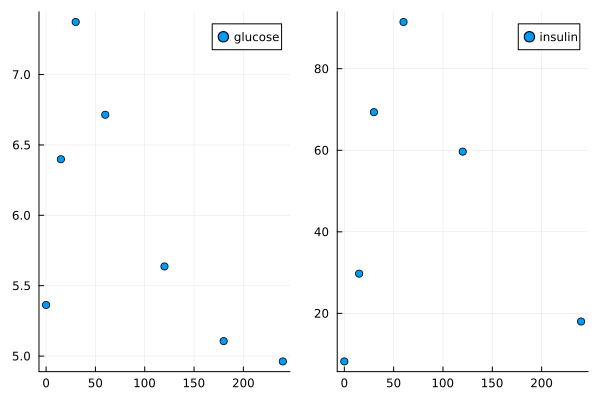

In [45]:
person = 1
meal_test = 1
scatter([time_G, time_I], [glc[meal_test,:,person], ins[meal_test,:,person]], layout = (1,2), label=["glucose" "insulin"],)

In [59]:
include("./EDES/including.jl")
columnnames = ["ID","Meal Test","Health status","k1","k5","k6", "k8"]

# extract the number of meal tests for each patient
counts = countmap(IDs)
n_meal_tests = maximum(values(counts))

parameter_df = DataFrame([name => [] for name in columnnames])
patients = [[glc[j,:,i], ins[j,:,i], BW, G_dose, time_G, time_I] for i in axes(IDs,1) for j in 1:n_meal_tests]
best_parameters_list = []
for i in 1#:size(IDs, 1)
    best_parameters = ParameterEstimation(patients[i]...)
    push!(best_parameters_list, best_parameters)
end

# plot output of the model with the best parameters
best_parameters = best_parameters_list[1]
println(best_parameters)


Optimization successful for this initial set, continuing...
Parameter estimation done!
[0.010534805984935395, 0.04889745609542905, 2.303195385900157, 4.41599766584129]


In [29]:
patients[1][1][1]

5.363070534761459

72.91897212436919


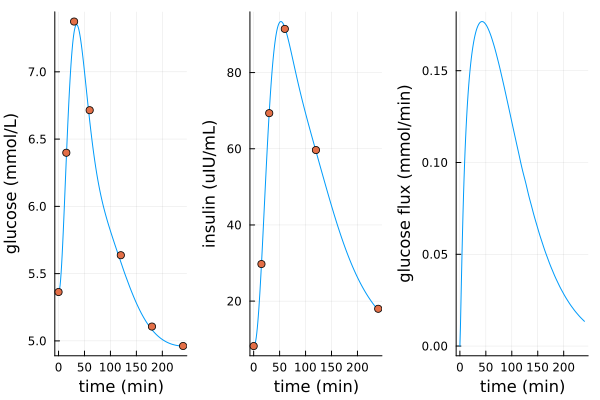

In [60]:
include("./EDES/including.jl")
estimated_parameters_names = ["k1", "k5", "k6", "k8"]
PlotMealResponse(estimated_parameters_names, best_parameters, patients[1][1][1], patients[1][2][1])
scatter!([time_G, time_I], [glc[meal_test,:,person], ins[meal_test,:,person]], layout = (1,2), label=["glucose" "insulin"],)

# Fit the EDES model


In [ ]:
using Distributed

n_cores = length(Sys.cpu_info())

# note that this is the same as of the synthetic patients, needs to change if we start changing the weight or the dose
BW = 70 
G_dose::Real = 75000.0


if nprocs()-1 < n_cores
    addprocs(n_cores-nprocs()+1, exeflags="--project")
end

@everywhere begin
    using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
    using Optimization, OptimizationOptimJL, LineSearches # for optimization
    using QuasiMonteCarlo # for LHS
    using Trapz
    include("./EDES/including.jl")
end

# extract the number of meal tests for each patient
counts = countmap(IDs)
n_meal_tests = maximum(values(counts))

patients = [[glc[j,:,i], ins[j,:,i], BW, G_dose, time_G, time_I] for i in axes(IDs,1) for j in 1:n_meal_tests]
results = pmap(x -> ParameterEstimation(x...), patients)

# close the parallel pool
rmprocs(procs()[2:end])

columnnames = ["ID","Meal Test","Health status","k1","k5","k6", "k8"]
# initialise the dataframe
df_fits = DataFrame()
for col in columnnames
    df_fits[!, Symbol(col)] = Float64[]
end

# Flatten the IDs matrix into a vector
IDs_vec = vec(IDs')
# Repeat the Health vector n times to match the length of IDs_vec
Health_vec = repeat(Health, inner = n_meal_tests)
# Create a vector for meal test numbers
meal_tests = repeat(1:n_meal_tests, size(IDs)[1])

for i in 1:length(IDs_vec)
    # Add the meal test number, health status, and ID to the start of the result vector
    prepend!(results[i], [IDs_vec[i], meal_tests[i], Health_vec[i]])
end

# Fill the dataframe with the results
for i in 1:length(results)
    println(results[i])
    push!(df_fits, transpose(results[i]))
end

      From worker 6:	Optimization successful for this initial set, continuing...
      From worker 6:	Parameter estimation done!
      From worker 5:	Optimization successful for this initial set, continuing...
      From worker 5:	Parameter estimation done!
      From worker 9:	Optimization successful for this initial set, continuing...
      From worker 4:	Optimization successful for this initial set, continuing...
      From worker 9:	Parameter estimation done!
      From worker 4:	Parameter estimation done!
      From worker 3:	Optimization successful for this initial set, continuing...
      From worker 3:	Parameter estimation done!
      From worker 8:	Optimization successful for this initial set, continuing...
      From worker 8:	Parameter estimation done!
      From worker 7:	Optimization successful for this initial set, continuing...
      From worker 7:	Parameter estimation done!
      From worker 5:	Optimization successful for this initial set, continuing...
      From worke

In [14]:
df_fits

Row,ID,Meal Test,Health status,k1,k5,k6,k8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.0,0.0,0.010597,0.0487406,2.22345,4.62042
2,1.0,2.0,0.0,0.0105898,0.0377038,2.87952,5.3739
3,1.0,3.0,0.0,0.0104491,0.0336622,3.08415,4.69267
4,1.0,4.0,0.0,0.0106295,0.0232053,2.88662,4.90104
5,1.0,5.0,0.0,0.0106367,0.017592,2.89517,5.03972
6,1.0,6.0,0.0,0.0105552,0.00895367,2.28821,5.01677
7,1.0,7.0,0.0,0.0103743,0.00505638,1.70599,5.0031
8,2.0,1.0,1.0,0.0104679,0.0401738,2.30648,5.11331
9,2.0,2.0,1.0,0.0105727,0.040269,2.18683,5.06824


In [18]:
#save the outputs
date_str = Dates.format(now(), "yyyy-mm-dd")
time_str = Dates.format(now(), "HH_MM")
date_time_str = date_str * "-" * time_str
file_name = "./Results/Synthetic_population_fits_$date_time_str.csv"

CSV.write(file_name, df_fits)

"./Results/Synthetic_population_fits_2024-08-01-11_42.csv"